#### Simple CNN for image classification

In [1]:
import torch
from torch import nn

In [209]:

def create_model(img_channels = 3):
    model = nn.Sequential()
    model.add_module('conv0', nn.Conv2d(in_channels=img_channels, out_channels=16, kernel_size=5, padding='same'))
    model.add_module('relu0', nn.ReLU())
    model.add_module('pool0', nn.MaxPool2d(kernel_size=2))

    model.add_module('conv1', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='same'))
    model.add_module('relu1', nn.ReLU())
    model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

    model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'))
    model.add_module('relu2', nn.ReLU())
    model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

    model.add_module('flatten', nn.Flatten())
    model.add_module('ln0', nn.Linear(4096, out_features=1024))
    model.add_module('relu4', nn.ReLU())
    model.add_module('ln1', nn.Linear(1024, out_features=10))
    return model


### Load and prepare an image dataset

In [132]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
image_path = './data/eurosat'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5))])
eurosat_dataset = datasets.EuroSAT(root=image_path, transform=transform, download=True)

#Randomize the dataset
torch.manual_seed(1)
train_len = int(0.85 * len(eurosat_dataset)) - int(0.85 * len(eurosat_dataset) * 0.2)
valid_len = int(0.85 * len(eurosat_dataset) * 0.2)
test_len = len(eurosat_dataset) - train_len - valid_len
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(eurosat_dataset, [train_len, valid_len, test_len])

#Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


#### Create the training loop function

In [212]:
def train(model, epochs, train_dl, valid_dl, gpu=False):
    if gpu:
        model.cuda()
    else:
        model.cpu()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_hist_train = [0] * epochs
    accuracy_hist_train = [0] * epochs

    loss_hist_valid = [0] * epochs
    accuracy_hist_valid = [0] * epochs

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            if gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            
            loss.backward() #Calculate tensor gradients with backpropagation
            optimizer.step() #Apply updates to weights using the optimizer gradient descent specif impl algorithm
            optimizer.zero_grad() #Reset the gradients for the next iteration
            
            #Calculate and save matrics
            loss_hist_train[epoch] += loss.item() * y_batch.size(0) #Add the loss to the loss history
            is_correct = (torch.argmax(pred, dim=1) == y_batch).cpu().float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= train_len
        accuracy_hist_train[epoch] /= train_len

        model.eval() #Set the model to evaluation mode
        with torch.no_grad(): #Turn off gradients
            for x_batch, y_batch in valid_dl:
                if gpu:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += (loss.item() * y_batch.size(0))
                is_correct = (torch.argmax(pred, dim=1) == y_batch).cpu().float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= valid_len
            accuracy_hist_valid[epoch] /= valid_len
        print(f'Epoch {epoch+1}/{epochs} accuracy: {accuracy_hist_train[epoch]:4f} valid_accuracy: {accuracy_hist_valid[epoch]:4f}')
    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid

In [213]:
def evaluate_model(model, data_loader, gpu=False):
    if gpu:
        model.cuda()
    else:
        model.cpu()    
    model.eval()
    y_list = []
    pred_list = []
    for x_batch, y_batch in data_loader:
        if gpu:
            x_batch = x_batch.cuda()
        pred = model(x_batch)
        pred_list.append(torch.argmax(pred, dim=1).cpu())
        y_list.append(y_batch)
    preds = torch.cat(pred_list, dim=0)
    y_true = torch.cat(y_list, dim=0)    
    #Calculate the accuracy
    is_correct = (preds == y_true).float()
    accuracy = is_correct.sum() / is_correct.numel()
    print(f'Accuracy: {accuracy:4f}')
    return accuracy

In [214]:
gpu_model = create_model()
loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = train(gpu_model, epochs=20, train_dl=train_loader, valid_dl=valid_loader, gpu=True)

Epoch 1/20 accuracy: 0.535784 valid_accuracy: 0.613508
Epoch 2/20 accuracy: 0.704466 valid_accuracy: 0.649673
Epoch 3/20 accuracy: 0.757244 valid_accuracy: 0.689978
Epoch 4/20 accuracy: 0.792756 valid_accuracy: 0.698257
Epoch 5/20 accuracy: 0.822495 valid_accuracy: 0.680392
Epoch 6/20 accuracy: 0.850763 valid_accuracy: 0.729194
Epoch 7/20 accuracy: 0.883115 valid_accuracy: 0.718954
Epoch 8/20 accuracy: 0.907462 valid_accuracy: 0.725490
Epoch 9/20 accuracy: 0.920370 valid_accuracy: 0.725926
Epoch 10/20 accuracy: 0.937691 valid_accuracy: 0.720479
Epoch 11/20 accuracy: 0.947930 valid_accuracy: 0.725708
Epoch 12/20 accuracy: 0.963671 valid_accuracy: 0.660349
Epoch 13/20 accuracy: 0.962037 valid_accuracy: 0.671678
Epoch 14/20 accuracy: 0.961601 valid_accuracy: 0.717211
Epoch 15/20 accuracy: 0.975272 valid_accuracy: 0.677778
Epoch 16/20 accuracy: 0.972440 valid_accuracy: 0.703268
Epoch 17/20 accuracy: 0.976253 valid_accuracy: 0.689760
Epoch 18/20 accuracy: 0.974074 valid_accuracy: 0.705011
E

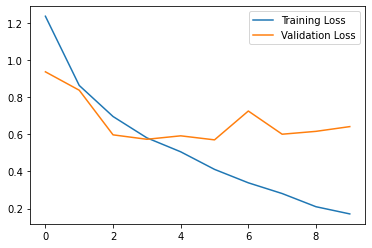

In [215]:
import matplotlib.pyplot as plt
#Plot the loss
plt.plot(loss_hist_train, label='Training Loss')
plt.plot(loss_hist_valid, label='Validation Loss')
plt.legend()
plt.show()


In [216]:
evaluate_model(gpu_model, test_loader, gpu=True)

Accuracy: 0.790414


tensor(0.7904)